New York Institute of Technology<br>
Course: DTSC 870 / Spring 2022<br>
Advisor: Dr. Cao<br>
Team: Michael Trzaskoma, Hui (Henry) Chen

----

This notebook is for the MRI tumor image classification (binary) model of the project. Therefore, this is part of Phase I of the project.

For more info, please visit the SVM pratical guide: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

Switch the Notebook runtime to GPU then check the available GPU.

# Set up

In [ ]:
# setup to see the execution time in each cell

!pip install ipython-autotime
!pip install directory_structure
!curl https://colab.chainer.org/install | sh -
%load_ext autotime

     |████████████████████████████████| 175 kB 34.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=54d2df23774b7f52701faf339d30b3fe3ae5c773510d9903d7479149a4529d65
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3427      0 --:--:-- --:--:-- --:--:--  3419
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
+ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 28.3 s (started: 2022-05-09 17:49:03 +00:00)


In [ ]:
import pandas as pd
import os
import glob
import PIL
from PIL import Image
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

time: 1.26 s (started: 2022-05-09 17:49:34 +00:00)


### No Img Aug

In [ ]:
# ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# # ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

# DATASET_01 = ROOT_DIR + "/datasets/01_MRI/Brain_tumor_images"
# DATASET_01_TRAIN = DATASET_01 + "/train"
# DATASET_01_TEST = DATASET_01 + "/test"

time: 1.37 ms (started: 2022-05-09 17:49:37 +00:00)


### Img Aug

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

DATASET_01 = ROOT_DIR + "/datasets/01_MRI"
DATASET_01_TRAIN = DATASET_01 + "/Aug_train"
DATASET_01_TEST = DATASET_01 + "/Aug_test"

time: 2.48 ms (started: 2022-05-09 18:28:01 +00:00)


In [ ]:
from directory_structure import Tree

os.chdir(DATASET_01)
print(Tree(os.getcwd()))

📂 01_MRI
|_📁 Brain_tumor_images
|_📁 Saved_CNN_Models
|_📁 Aug_train
|_📁 Aug_test
|_📁 Brain_tumor_downsampling
|_📄 Copy of Normal (2).jpg
time: 9.87 ms (started: 2022-05-09 18:28:01 +00:00)


# Preprocessing

## Untility func

In [ ]:
#Figuring out loading images to preprocess

def get_total_train_num(dir):
  return len(glob.glob(dir))

time: 1.36 ms (started: 2022-05-09 18:28:04 +00:00)


In [ ]:
def get_data_df(dir):
  # modified code from: https://www.kaggle.com/namgalielei/simple-load-images-and-count-number-of-each-class

  train_df = pd.DataFrame()

  trainset = glob.glob(dir)

  train_df['file'] = [img.split("/")[-1] for img in trainset]
  train_df['class'] = [img.split("/")[-2] for img in trainset]

  return train_df

time: 4.93 ms (started: 2022-05-09 18:28:05 +00:00)


In [ ]:
def generate_set(df, dir):

  # new_df = pd.DataFrame()
  pixels = []
  class_ = []

  # trainset = glob.glob(dir)
  for i in range(len(df.index)):
    # get the absolute img path
    # e.g., Brain_tumor_images/<train or test>/<class label>/<file name>
    path = dir + "/" + df.iloc[i]["class"] + "/" +df.iloc[i]["file"]
    # print(img)
    img = Image.open(path)
    # print("Img: {} \tClass: {}".format(np.array(img).flatten(), df.iloc[i]["class"]))
    pixels.append(cp.asnumpy(cp.array(img)).flatten())
    # pixels.append(np.array(img))

    # y_true encoding here
    if df.iloc[i]["class"] == "Normal":
      class_.append(0)
    else:
      class_.append(1)

  # train_df['file'] = [img.split("/")[-1] for img in trainset]
  # train_df['class'] = [img.split("/")[-2] for img in trainset]

  # return train_df
  return pixels, class_

time: 16.6 ms (started: 2022-05-09 18:28:05 +00:00)


## Generate Train & Test set

Generate a general dataframe

In [ ]:
mri_df_train = get_data_df(DATASET_01_TRAIN+"/*/*.jpg")
mri_df_test = get_data_df(DATASET_01_TEST+"/*/*.jpg")

time: 8.16 s (started: 2022-05-09 18:28:05 +00:00)


Splitting the dataset into train and test sets with a ratio of 0.7:0.3

In [ ]:
x_train, y_train = generate_set(mri_df_train, DATASET_01_TRAIN)
x_test, y_test = generate_set(mri_df_test, DATASET_01_TEST)

time: 5min 29s (started: 2022-05-09 18:28:13 +00:00)


In [ ]:
# np.array().shape
print("x_train shape: {}\ny_train shape: {}\nx_test shape: {}\ny_test shape: {}".format(np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape))

x_train shape: (279, 196608)
y_train shape: (279,)
x_test shape: (279, 196608)
y_test shape: (279,)
time: 39.8 ms (started: 2022-05-09 18:33:42 +00:00)


## Get the dimensions of the data

In [ ]:
print(len(x_train[0]))

196608
time: 1.79 ms (started: 2022-05-09 18:33:42 +00:00)


In [ ]:
# print(len(mri_df_train))
# print(len(mri_df_test))
mri_df_train.head()
img = Image.open(DATASET_01_TRAIN +"/"+ mri_df_train['class'].iloc[0]+"/"+ mri_df_train['file'].iloc[0])
w, h = img.size
w, h
# img

(256, 256)

time: 8.01 ms (started: 2022-05-09 18:33:42 +00:00)


In [ ]:
# len(img.getbands())

time: 775 µs (started: 2022-05-05 18:34:25 +00:00)


In [ ]:
img = np.array(img)

# Code ref: https://gist.github.com/liuhh02/ade48d822139006f98d8f05681209ab6

# find number of channels
if img.ndim == 2:
    channels = 1
    print("image has 1 channel")
else:
    channels = img.shape[-1]
    print("image has", channels, "channels")

image has 3 channels
time: 12.8 ms (started: 2022-05-05 18:34:25 +00:00)


In [ ]:
# arr = np.array(img)
# print(arr)

time: 2.9 ms (started: 2022-05-05 18:34:25 +00:00)


In [ ]:
# print(arr.flatten())

time: 978 µs (started: 2022-05-05 18:34:25 +00:00)


# Feature Engineering

## Dimensionality Reduction (PCA)

Unbalanced problem with SVM:
https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems

For more info, please visit plotly doc here:
1. https://plotly.com/python/pca-visualization/
2. https://machinelearningmastery.com/principal-components-analysis-for-dimensionality-reduction-in-python/
3. https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
4. https://github.com/StatQuest/pca_demo/blob/master/pca_demo.py
5. https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=explained_variance_ratio_%20method%20of%20PCA%20is,scaled%20before%20applying%20PCA%20technique.

Backup the X train and test set

In [ ]:
# backup the train and test sets
x_train_org, x_test_org = x_train, x_test

time: 1.07 ms (started: 2022-05-09 18:33:42 +00:00)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

time: 1.31 ms (started: 2022-05-09 18:33:42 +00:00)


In [ ]:
pca = PCA()

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

time: 20 s (started: 2022-05-09 18:33:42 +00:00)


In [ ]:
print("Original X train shape: {}".format(np.array(x_train).shape))
print("X Train shape after PCA: {}".format(x_train_pca.shape))

print("Original X test shape: {}".format(np.array(x_test).shape))
print("X test shape after PCA: {}".format(x_test_pca.shape))

Original X train shape: (279, 196608)
X Train shape after PCA: (279, 279)
Original X test shape: (279, 196608)
X test shape after PCA: (279, 279)
time: 44.2 ms (started: 2022-05-09 18:34:02 +00:00)


In [ ]:
# header = ["PC"+str(i) for i in range(1, len(x_train_pca[0]) + 1)]
# header

time: 568 µs (started: 2022-05-09 18:34:02 +00:00)


Comment out for actual run.

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    x_train_pca,
    # x_train_df,
    labels=labels,
    # dimensions=(0, 1),
    dimensions=range(4),
    # color=x_train_df['class'],
)
fig.update_traces(diagonal_visible=False)
fig.show()

time: 1.2 s (started: 2022-05-05 18:34:52 +00:00)


Display the cumulative of variance.

In [ ]:
# import plotly.express as px

# pca = PCA()
# components = pca.fit_transform(x_train_sc)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
exp_var_cumul_round = np.round_(exp_var_cumul, decimals = 4)
print(exp_var_cumul_round)

[0.18   0.2252 0.2688 0.3035 0.3304 0.355  0.3775 0.3955 0.4112 0.4266
 0.4414 0.4545 0.4671 0.4792 0.491  0.5019 0.5126 0.5225 0.5322 0.5414
 0.55   0.5583 0.5666 0.5747 0.5821 0.5894 0.5964 0.6032 0.6098 0.6162
 0.6223 0.6283 0.6341 0.6397 0.6452 0.6507 0.6559 0.6608 0.6658 0.6706
 0.6753 0.68   0.6845 0.6889 0.6932 0.6975 0.7016 0.7058 0.7098 0.7138
 0.7177 0.7215 0.7253 0.729  0.7327 0.7363 0.7398 0.7433 0.7467 0.7499
 0.7532 0.7564 0.7595 0.7626 0.7657 0.7687 0.7717 0.7746 0.7775 0.7804
 0.7832 0.7859 0.7886 0.7912 0.7939 0.7965 0.799  0.8016 0.8041 0.8065
 0.8089 0.8113 0.8136 0.8159 0.8182 0.8204 0.8226 0.8248 0.827  0.8291
 0.8312 0.8333 0.8353 0.8374 0.8394 0.8414 0.8433 0.8453 0.8472 0.849
 0.8509 0.8527 0.8545 0.8563 0.8581 0.8598 0.8615 0.8632 0.8649 0.8666
 0.8682 0.8698 0.8715 0.8731 0.8746 0.8762 0.8777 0.8793 0.8808 0.8823
 0.8837 0.8852 0.8867 0.8881 0.8895 0.8909 0.8923 0.8937 0.8951 0.8964
 0.8978 0.8991 0.9004 0.9017 0.903  0.9043 0.9056 0.9068 0.9081 0.9093
 0.9105

In [ ]:
# get a list of # of components
num_comp = range(1, exp_var_cumul_round.shape[0] + 1)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

time: 2.03 ms (started: 2022-05-09 18:34:03 +00:00)


In [ ]:
fig = px.line(
    x=num_comp,
    y=exp_var_cumul_round,
    labels={"x": "# Components", "y": "Cumulative Explained Variance"},
    title = "# of components V.S. variance",
    # markers=True
)

fig.show()

time: 107 ms (started: 2022-05-05 18:34:54 +00:00)


In [ ]:
selected_exp_var = [0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1.0]
selected_num_comp = [46, 77, 131, 179, 206, 245, 275]

time: 1.56 ms (started: 2022-05-09 18:34:03 +00:00)


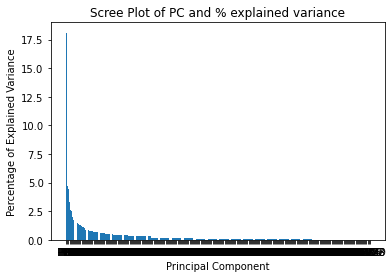

time: 4.09 s (started: 2022-05-09 17:58:38 +00:00)


In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

fig = px.bar(
    x=range(1,len(per_var)+1), 
    y=per_var, 
    title='Scree Plot of # of components and % of explained variance',
    labels={"x": "# Components", "y": "% of Explained Variance"},
)
fig.show()

# matplotlib version
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot of PC and % explained variance')
plt.show()

### Selected variance listing

Here we are going to select a list of different variance to experiment how the % of the variance would impact the model's accuracy.

Here, we are selecting 70%, 80%, 90%, 95%, 97%, 99%, and 100% variance for PCA.

In [ ]:
# a list of variance to experiment
selected_exp_var = [0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1.0]
selected_num_comp = [46, 77, 131, 179, 206, 245, 279]
# selected_num_comp = list()

# # loop through the two list to find the cooresponding 
# #cumulative variance and # of comp
# for i in range(len(exp_var_cumul_round)):
#   for j in range(len(selected_exp_var)):
#     if exp_var_cumul_round[i] == selected_exp_var[j]:
#       selected_num_comp.append(num_comp[i])

# # we have to trim the extra 1.0 (aka 100% variance) since we round
# # the variance into 2 decimal. Then we add the variance of 100%, 
# # which is 275 # of comp.
# selected_num_comp = selected_num_comp[:len(selected_exp_var)-1]
# selected_num_comp.append(275)

time: 6.51 ms (started: 2022-05-09 18:34:03 +00:00)


In [ ]:
# a list of # of comp that we are going to experiment
selected_num_comp

[46, 77, 131, 179, 206, 245, 279]

time: 3.2 ms (started: 2022-05-09 17:58:44 +00:00)


## Standardization

In [ ]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# x_train_sc = preprocessing.scale(np.array(x_train))
# x_test_sc = preprocessing.scale(np.array(x_test))

# x_train_sc = np.divide(np.array(x_train), 255.0)
# x_test_sc = np.divide(np.array(x_test), 255.0)

# x_train_sc = preprocessing.scale(np.array(x_train).T)
# x_test_sc = preprocessing.scale(np.array(x_test).T)

sc = StandardScaler()

x_train_sc = sc.fit_transform(np.array(x_train_pca))
x_test_sc = sc.transform(np.array(x_test_pca))

time: 9.51 ms (started: 2022-05-09 18:34:03 +00:00)


In [ ]:
# x_train = np.divide(x_train, 255)
# x_test = np.divide(x_test, 255)

# x_mean = x_train.mean(axis=0)

# x_train_nm = x_train - x_mean
# x_test_nm = x_test - x_mean

# x_mean

# x_train_nm[0]

time: 3.48 ms (started: 2022-05-05 18:40:38 +00:00)


In [ ]:
x_train_sc.shape

(279, 279)

time: 4.33 ms (started: 2022-05-05 18:40:38 +00:00)


In [ ]:
header = ["PCA"+str(i) for i in range(1, x_train_pca.shape[1] + 1)]
x_train_df = pd.DataFrame(x_train_sc, columns=header)
x_train_df['class'] = y_train

# x_train_df

time: 2.72 ms (started: 2022-05-09 18:34:03 +00:00)


# SVM with PCA

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC

time: 1.95 ms (started: 2022-05-09 17:59:16 +00:00)


## Setup

Define a list of x_train from the given # of components for PCA AND the model.

In [ ]:
def generate_PCA_set(comp, x_train, x_test):
  pca = PCA(n_components=comp)
  __x_train__ = pca.fit_transform(x_train)
  __x_test__ = pca.transform(x_test)
  return __x_train__, __x_test__

time: 1.93 ms (started: 2022-05-09 17:59:16 +00:00)


In [ ]:
def get_model():
  return SVC(random_state=1)

time: 774 µs (started: 2022-05-09 17:59:17 +00:00)


In [ ]:
def feature_scale(_x_train_, _x_test_):
  sc = StandardScaler()

  train_sc = sc.fit_transform(_x_train_)
  test_sc = sc.transform(_x_test_)

  return train_sc, test_sc

time: 1.7 ms (started: 2022-05-09 17:59:17 +00:00)


In [ ]:
def feature_scale2(_x_train_):
  sc = StandardScaler()

  train_sc2 = sc.fit_transform(np.array(_x_train_))

  return train_sc2

time: 1.89 ms (started: 2022-05-09 17:59:18 +00:00)


## Model Evaluation

We gonna perform K fold (10 folds) cross validation targetting the highest accuracy while maintaining the data distribution per class. Luckily, `StratifiedKFold` from the scikit learn is able to achieve that.

Unweighted accuracy: 
* https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score
* https://stackoverflow.com/questions/65848571/why-is-cross-val-score-different-to-when-i-calculate-it-manually

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from numpy import mean

time: 1.22 ms (started: 2022-05-09 18:00:31 +00:00)


Here, we are doing CV with <b>training set</b> only.

In [ ]:
df_temp = pd.DataFrame(x_train)
df_temp['class'] = y_train
df_temp.shape

(279, 196609)

time: 37.3 s (started: 2022-05-09 18:34:03 +00:00)


In [ ]:
# go through all PCA components

x_train_exp = list()

for i in range(len(selected_num_comp)):
  temp_train, temp_test = generate_PCA_set(selected_num_comp[i], x_train, x_test)
  
  x_train_exp.append({
      "num_comp": selected_num_comp[i],
      "variance_": selected_exp_var[i],
      "model": get_model(),
      "x_train_": temp_train,
      "y_train_": y_train,
      "x_test_": temp_test,
      "y_test_": y_test,
  })

time: 1min 51s (started: 2022-05-09 18:34:40 +00:00)


### Cross Validation Accuracies

Comment out for actual run.

In [ ]:
# crossValidate_weighted = list()
# crossValidate_unweighted = list()
# kfold_num = 5

# for item in x_train_exp:
#   # print("\n########################################################################")
#   # print("{} % variance PCA".format(item['variance_'] * 100))
#   # print("########################################################################")
#   # define the k fold
#   kfold = StratifiedKFold(n_splits=kfold_num, random_state=1, shuffle=True)

#   x_train_evaluation = feature_scale2(item["x_train_"])

#   # retrieve the cross validation score
#   unweighted_results = cross_val_score(
#       item["model"],
#       x_train_evaluation,
#       item["y_train_"],
#       cv=kfold,
#       scoring='balanced_accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   weighted_results = cross_val_score(
#       item["model"],
#       x_train_evaluation,
#       item["y_train_"],
#       cv=kfold,
#       scoring='accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   # # append the score val
#   # results.append(unweighted_results)
#   # names.append(item["variance_"])

#   # output the score data
#   crossValidate_weighted.append(mean(weighted_results))
#   crossValidate_unweighted.append(mean(unweighted_results))
#   # print("Cross Validation Accuracies:")
#   # print('Unweighted Accuracy: %0.6f' % (mean(unweighted_results)))
#   # print('Weighted Accuracy: %0.6f' % (mean(weighted_results)))
#   # print("\n")

time: 4.87 ms (started: 2022-05-05 18:41:25 +00:00)


#### CV Accuracy Result Visualization

Comment out for actual run.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=selected_exp_var, 
#     y=crossValidate_weighted,
#     mode='lines',
#     name='Weighted Training Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=selected_exp_var, 
#     y=crossValidate_unweighted,
#     mode='lines',
#     name='Unweighted Training Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )


# fig.update_layout(
#     title="Cross Validation accuracies amongst different variance % in the PCA",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 7.58 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# results, names = list(), list()
# var_kfold_results = list()
# kfold_num = 5

# # print("Unweighted accruacy\n")
# for item in x_train_exp:
#   print("\n########################################################################")
#   print("{} % variance PCA".format(item['variance_'] * 100))
#   print("########################################################################")
#   # define the k fold
#   kfold = StratifiedKFold(n_splits=kfold_num, random_state=1, shuffle=True)

#   # retrieve the cross validation score
#   unweighted_results = cross_val_score(
#       item["model"],
#       item["x_train_"],
#       x_train_df['class'],
#       cv=kfold,
#       scoring='balanced_accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   weighted_results = cross_val_score(
#       item["model"],
#       item["x_train_"],
#       x_train_df['class'],
#       cv=kfold,
#       scoring='accuracy',
#       # scoring='accuracy',
#       n_jobs=-1
#     )
  
#   # append the score val
#   results.append(unweighted_results)
#   names.append(item["variance_"])

#   # output the score data
#   print("Training set:")
#   print('Unweighted Accuracy: %0.6f' % (mean(unweighted_results)))
#   print('Weighted Accuracy: %0.6f' % (mean(weighted_results)))

#   # keep track of the model array
#   i = 0

#   # track the all unweighted and weighted accuracies during the fold training
#   vali_unw_acc, vali_wei_acc = list(), list()


#   # fit the train and test data index into the model
#   for train, test in kfold.split(item['x_train_'], x_train_df['class']):
#     # get the train and validation sets
#     x_train_, y_train_ = np.array(item['x_train_'][train]), np.array(x_train_df['class'][train])
#     # x_test_, y_test_ = np.array(df[test]), np.array(df['class'][test])

#     # print(x_train_.shape)
#     # print(y_train_.shape)
#     # print("\n")
    
#     # save the trained model to 'var_kfold_results' array
#     item["model"].fit(x_train_, y_train_)

#     # make a classification with the validation set
#     y_pred = item["model"].predict(item["x_test_"])

#     # calculate the accuracies and save it
#     # unweighted and weighted accuracy for this fold
#     unweighted = balanced_accuracy_score(y_test, y_pred)
#     weighted = accuracy_score(y_test, y_pred)

#     # save the current accuracy
#     vali_unw_acc.append(unweighted)
#     vali_wei_acc.append(weighted)
#     # end inner loop here

#     # Note: we have to manually calculate the gamma since scikit learn does not
#     # provide that attribute with SCV obj.
#     # Ref: https://stackoverflow.com/questions/59660939/default-value-of-gamma-svc-sklearn
#     # calculate the gamma value
#     n_features = x_train_.shape[1]
#     gamma = 1/(n_features * x_train_.var())
#     print('gamma: %.09f' % gamma)



#   var_kfold_results.append({
#       "%_variance": item['variance_'],
#       "unweighted_train_results": mean(unweighted_results),
#       "weighted_train_results": mean(weighted_results),
#       "unweighted_validate_acc": mean(vali_unw_acc),
#       "weighted_validate_acc": mean(vali_wei_acc),
#   })

#   print("\nValidation set:")
#   print(f"Unweighted Accuracy: %0.6f" %  var_kfold_results[i]["unweighted_validate_acc"])
#   print(f"Weighted Accuracy: %0.6f" %  var_kfold_results[i]["weighted_validate_acc"])

#   i += 1

time: 21 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# for item in var_kfold_results:
#   print(item)

time: 949 µs (started: 2022-05-05 18:41:25 +00:00)


Since we have the models from the kfold, let's plot the results on the graph.

In [ ]:
# # train set
# unweighted_train_acc = list()
# weighted_train_acc = list()
# # validation set
# unweighted_vali_acc = list()
# weighted_vali_acc = list()

# for item in var_kfold_results:
#   unweighted_train_acc.append(item["unweighted_train_results"])
#   weighted_train_acc.append(item["weighted_train_results"])
#   unweighted_vali_acc.append(item["unweighted_validate_acc"])
#   weighted_vali_acc.append(item["weighted_validate_acc"])

# kfold_results_df = pd.DataFrame()
# kfold_results_df['unweighted_train_results'] = unweighted_train_acc
# kfold_results_df['weighted_train_results'] = weighted_train_acc
# kfold_results_df['unweighted_validate_acc'] = unweighted_vali_acc
# kfold_results_df['weighted_validate_acc'] = weighted_vali_acc
# kfold_results_df['variance%'] = selected_exp_var

time: 7.57 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# kfold_results_df

time: 803 µs (started: 2022-05-05 18:41:25 +00:00)


 Evaluation Visualization

# FINAL REPORT USE

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=kfold_results_df["variance%"], 
#     y=kfold_results_df["unweighted_train_results"],
#     mode='lines',
#     name='Unweighted Training Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=kfold_results_df["variance%"], 
#     y=kfold_results_df["weighted_train_results"],
#     mode='lines',
#     name='Weighted Training Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=kfold_results_df["variance%"], 
#     y=kfold_results_df["unweighted_validate_acc"],
#     mode='lines',
#     name='Unweighted Validation Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=kfold_results_df["variance%"], 
#     y=kfold_results_df["weighted_validate_acc"],
#     mode='lines',
#     name='Weighted Validation Accuracy',
#     marker=dict(
#         color='cyan',
#         size=10
#     ))
# )

# fig.update_layout(
#     title="SVM K-Fold (" + str(kfold_num) + " folds) validation accuracy with PCA explained % variance (aug)",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 13.2 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# for item in x_train_exp:
#   # print(item['model'].get_params())
#   print(item['model']._gamma)

time: 1.11 ms (started: 2022-05-05 18:41:25 +00:00)


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

time: 1.73 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# # store a list of best parameter of SVM
# w_best_para = list()
# uw_best_para = list()

time: 660 µs (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# # a list of set of parameter for the SVM
# tuned_paramteres = [
#   {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 20, 50, 70, 100, 'scale'], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
#   {'kernel': ['linear', 'sigmoid', ], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
#   {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'C': [0.03125, 0.0001, 0.001, 0.01,0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 25.0, 50.0, 100.0, 1000.0]},
# ]

time: 1.79 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# x_train_exp2 = list()

# for i in range(len(selected_num_comp)):
#   temp_train, temp_test = generate_PCA_set(selected_num_comp[i], x_train, x_test)
  
#   x_train_exp2.append({
#       "num_comp": selected_num_comp[i],
#       "variance_": selected_exp_var[i],
#       "model": get_model(),
#       "x_train_": temp_train,
#       "x_test_": temp_test,
#   })

time: 4.96 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# parameterTune_results = list()
# parameterTune_kfold_results = list()

time: 890 µs (started: 2022-05-05 18:41:25 +00:00)


Experiment 2.1

TBC

In [ ]:
# for item in x_train_exp2:

#   x_train_sc, x_test_sc = feature_scale(item["x_train_"], np.array(item["x_test_"]))
#   # print("x_train sample size: {}, x_test sample size: {}".format(np.array(item["x_train_"]).shape, np.array(item["x_test_"]).shape))

#   # the weighted
#   SVM_GRID_w = GridSearchCV(SVC(), tuned_paramteres, scoring='accuracy', n_jobs=-1)
#   SVM_GRID_w.fit(x_train_sc, y_train)
#   y_pred = SVM_GRID_w.predict(x_test_sc)

#   w_acc = accuracy_score(y_test, y_pred)
#   # print("Y Test: {}\nY Pred: {}".format(np.array(y_test_).shape, np.array(y_pred).shape))
#   print("The weighted accuracy: {}".format(w_acc))

#   # the unweighted
#   SVM_GRID_uw = GridSearchCV(SVC(), tuned_paramteres, scoring='balanced_accuracy', n_jobs=-1)
#   SVM_GRID_uw.fit(x_train_sc, y_train)
#   unw_y_pred = SVM_GRID_uw.predict(x_test_sc)

#   uw_acc = balanced_accuracy_score(y_test, unw_y_pred)
#   print("The unweighted accuracy: {}".format(uw_acc))

#   # calculate the gamma value
#   # n_features = x_train_sc.shape[1]
#   # gamma = 1/(n_features * x_train_sc.var())
#   # print('Gamma: %.09f' % gamma)
    
#   print("The best Weighted para: ")
#   print(SVM_GRID_w.best_params_)

#   print("The best Unweighted para: ")
#   print(SVM_GRID_uw.best_params_)
#   print("")

time: 8.49 ms (started: 2022-05-05 18:41:25 +00:00)


### Paramter evaluation

In [ ]:
exper22_variance = list()
exper22_weighted_cv = list()
exper22_unweighted_cv = list()
exper22_weighted_validate = list()
exper22_unweighted_validate = list()

def get_optimal_para(kfold_num, tune_para):

  # print("Unweighted accruacy\n")
  for item in x_train_exp2:
    print("\n########################################################################")
    print("{} % variance PCA".format(item['variance_'] * 100))
    print("########################################################################")
    # define the k fold
    kfold = StratifiedKFold(n_splits=kfold_num, random_state=1, shuffle=True)

    x_train_evaluation = feature_scale2(item["x_train_"])

    # retrieve the cross validation score
    unweighted_results = cross_val_score(
        item["model"],
        x_train_evaluation,
        x_train_df["class"],
        cv=kfold,
        scoring='balanced_accuracy',
        # scoring='accuracy',
        n_jobs=-1
      )
    
    weighted_results = cross_val_score(
        item["model"],
        x_train_evaluation,
        x_train_df["class"],
        cv=kfold,
        scoring='accuracy',
        # scoring='accuracy',
        n_jobs=-1
      )
    
    # # append the score val
    # results.append(unweighted_results)
    # names.append(item["variance_"])

    # output the score data
    print("Cross Validation Accuracies:")
    print('Unweighted Accuracy: %0.6f' % (mean(unweighted_results)))
    print('Weighted Accuracy: %0.6f' % (mean(weighted_results)))
    print("\n")

    # keep track of the model array
    i = 0
    j = 1

    # track the all unweighted and weighted accuracies during the fold training
    test_unw_acc, test_wei_acc = list(), list()


    # fit the train and test data index into the model
    for train, test in kfold.split(item['x_train_'], x_train_df["class"]):
      print("Fold number: " + str(j))

      ########################## Validation Set ##########################
      # get the train and validation sets
      x_train_, y_train_ = np.array(item['x_train_'][train]), np.array(x_train_df["class"][train])
      x_test_, y_test_ = np.array(item['x_train_'][test]), np.array(x_train_df["class"][test])

      x_train_sc, x_test_sc = feature_scale(x_train_, x_test_)

      # save the trained model to 'var_kfold_results' array
      # item["model"].fit(x_train_.T, y_train_.T)

      # the weighted
      SVM_GRID_w = GridSearchCV(item["model"], tune_para, scoring='accuracy')
      SVM_GRID_w.fit(x_train_sc, y_train_.T)
      y_pred = SVM_GRID_w.predict(x_test_sc)

      w_acc = accuracy_score(y_test_, y_pred)
      # print("Y Test: {}\nY Pred: {}".format(np.array(y_test_).shape, np.array(y_pred).shape))
      test_wei_acc.append(w_acc)

      # the unweighted
      SVM_GRID_uw = GridSearchCV(item["model"], tune_para, scoring='balanced_accuracy')
      SVM_GRID_uw.fit(x_train_sc, y_train_.T)
      unw_y_pred = SVM_GRID_uw.predict(x_test_sc)

      uw_acc = balanced_accuracy_score(y_test_, unw_y_pred)
      test_unw_acc.append(uw_acc)
      
      # calculate the gamma value
      # n_features = x_train_sc.shape[1]
      # gamma = 1/(n_features * x_train_sc.var())
      # print('Gamma: %.09f' % gamma)
        
      print("The best weighted para: ")
      print(SVM_GRID_w.best_params_)
      print(f"Accuracy: %0.6f" % (w_acc))
      # print("====")
      print("The best unweighted para: ")
      print(SVM_GRID_uw.best_params_)
      print(f"Accuracy: %0.6f" % (uw_acc))
      print("")

      j += 1
      # end inner loop
    
    # parameterTune_results.append({
    #   "variance%": item["variance_"],
    #   "weighted_train": mean(weighted_results),
    #   "unweighted_train": mean(unweighted_results),
    #   "weighted_validation": mean(test_wei_acc),
    #   "unweighted_validation": mean(test_unw_acc)
    # })
    exper22_variance.append(item["variance_"])
    exper22_weighted_cv.append(mean(weighted_results))
    exper22_unweighted_cv.append(mean(unweighted_results))
    exper22_weighted_validate.append(mean(test_wei_acc))
    exper22_unweighted_validate.append(mean(test_unw_acc))

    print("\nMean Validation set:")
    print(f"Weighted accuracy: %0.6f" % (mean(test_wei_acc)))
    print(f"Unweighted accuracy: %0.6f" % (mean(test_unw_acc)))

    i += 1
    # end outter loop

time: 159 ms (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# get_optimal_para(5, tuned_paramteres)

time: 976 µs (started: 2022-05-05 18:41:25 +00:00)


#### Evaluation visualization

Comment out for actual run

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Line(
#     x=exper22_variance,
#     y=exper22_weighted_cv,
#     mode='lines',
#     name='Weighted CV Accuracy',
#     marker=dict(
#         color='red',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper22_variance,
#     y=exper22_unweighted_cv,
#     mode='lines',
#     name='Unweighted CV Accuracy',
#     marker=dict(
#         color='green',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper22_variance,
#     y=exper22_weighted_validate,
#     mode='lines',
#     name='Weighted Validation Accuracy',
#     marker=dict(
#         color='blue',
#         size=10
#     ))
# )

# fig.add_trace(go.Line(
#     x=exper22_variance,
#     y=exper22_unweighted_validate,
#     mode='lines',
#     name='Unweighted Validation Accuracy',
#     marker=dict(
#         color='cyan',
#         size=10
#     ))
# )



# fig.update_layout(
#     title="CV and validation accuracies amongst different variance % in the PCA",
#     xaxis_title="% of Explained Variance",
#     yaxis_title="Accuracy (%)"
# )
# fig.update_traces(mode='markers+lines')

# fig.show()

time: 10.1 ms (started: 2022-05-05 18:41:25 +00:00)


## Training with the best parameters

As we can see, it turns out that the best hyperparameter are:
* `{'C': 4.0, 'gamma': scale, 'kernel': 'rbf'}`

  In both weighted and unweighted accuracies from the second and fourth folders.

* `'C': 3.0, 'gamma': 0.01, 'kernel': 'rbf'`

  All occured in both weighted and unweighted accuracies on the first fold.

<br>

Therefore, we need to replace the parameters with the original default parameters.

In [ ]:
def tuned_svm():
  return SVC(C=4.0, gamma="scale", kernel='rbf', random_state=1)


def tuned_svm2():
  return SVC(C=3.0, gamma='scale', kernel='rbf', random_state=1)

time: 1.66 ms (started: 2022-05-09 18:05:40 +00:00)


In [ ]:
# for batch PCA run

pca_tuned_para_svm1 = x_train_exp

for item in pca_tuned_para_svm1:
  item['model'] = tuned_svm()

time: 2.16 ms (started: 2022-05-09 18:37:21 +00:00)


In [ ]:
# indexs = 1

# temp_train, temp_test = generate_PCA_set(selected_num_comp[indexs], x_train, x_test)

# pca_tuned_para_svm1 = {
#       "num_comp": selected_num_comp[indexs],
#       "variance_": selected_exp_var[indexs],
#       "model": tuned_svm2(),
#       "x_train_": temp_train,
#       "y_train_": y_train,
#       "x_test_": temp_test,
#       "y_test_": y_test,
#   }

time: 11.2 s (started: 2022-05-05 18:41:25 +00:00)


In [ ]:
# batch PCA training

tunePara_uw_train_acc = list()
tunePara_w_train_acc = list()
tunePara_uw_test_acc = list()
tunePara_w_test_acc = list()

for item in pca_tuned_para_svm1:
  
  # scaling the features aftert the PCA
  # sc = StandardScaler()
  # x_train_sc23 = sc.fit_transform(item["x_train_"])
  # x_test_sc23 = sc.transform(item["x_test_"])
  x_train_sc23, x_test_sc23 = feature_scale(item["x_train_"], item["x_test_"])

  # train the model
  item['model'].fit(x_train_sc23, y_train)

  # predict the train set
  y_trainHat = item["model"].predict(x_train_sc23)

  # predict the test set
  y_testHat = item["model"].predict(x_test_sc23)

  # calculate the gamma value
  n_features = x_train_sc23.shape[1]
  gamma = 1/(n_features * x_train_sc23.var())
  print('Gamma: %.09f' % gamma)
  
  # save the accuracy results
  tunePara_uw_train_acc.append(balanced_accuracy_score(y_train, y_trainHat))
  tunePara_w_train_acc.append(accuracy_score(y_train, y_trainHat))
  tunePara_uw_test_acc.append(balanced_accuracy_score(y_test, y_testHat))
  tunePara_w_test_acc.append(accuracy_score(y_test, y_testHat))

  print("UW ACC: {}".format(balanced_accuracy_score(y_test, y_testHat)))

  # np.array().shape
  # print("x_train shape: {}\n x_train after scaling shape: {}".format(np.array(item["x_train_"]).shape, np.array(x_train_sc23).shape))

Gamma: 0.021739130
UW ACC: 0.9192283398252448
Gamma: 0.012987013
UW ACC: 0.9370196862827667
Gamma: 0.007633588
UW ACC: 0.9183861459100957
Gamma: 0.005586592
UW ACC: 0.9085166859669439
Gamma: 0.004854369
UW ACC: 0.9003316138540899
Gamma: 0.004081633
UW ACC: 0.8653279292557111
Gamma: 0.003597122
UW ACC: 0.8350352668701968
time: 276 ms (started: 2022-05-09 18:37:26 +00:00)


In [ ]:
# single SVM train: 80% variance


def single_svm_train(model_data: dict):
  x_train_sc_, x_test_sc_ = feature_scale(model_data["x_train_"], model_data["x_test_"])

  # train the model
  model_data['model'].fit(x_train_sc_, y_train)

  # predict the train set
  y_trainHat = model_data["model"].predict(x_train_sc_)

  # predict the test set
  y_testHat = model_data["model"].predict(x_test_sc_)

  # calculate the gamma value
  n_features = x_train_sc_.shape[1]
  gamma = 1/(n_features * x_train_sc_.var())
  print('Gamma: %.09f' % gamma)


single_svm_train(pca_tuned_para_svm1)

Gamma: 0.012987013
time: 40.9 ms (started: 2022-05-05 18:45:05 +00:00)


### Tuned parameter accuracy visualization

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_uw_test_acc,
    mode='lines',
    name='Unweighted Test Accuracy',
    marker=dict(
        color='red',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_w_test_acc,
    mode='lines',
    name='Weighted Test Accuracy',
    marker=dict(
        color='green',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_w_train_acc,
    mode='lines',
    name='Weighted Training Accuracy',
    marker=dict(
        color='blue',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_uw_train_acc,
    mode='lines',
    name='Unweighted Training Accuracy',
    marker=dict(
        color='cyan',
        size=10
    ))
)

fig.update_layout(
    title="Parameter-tuning SVM (PCA) weighted and unweighted accuracies (aug)",
    xaxis_title="% of Explained Variance",
    yaxis_title="Accuracy (%)"
)
fig.update_traces(mode='markers+lines')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 63.2 ms (started: 2022-05-09 18:06:09 +00:00)


In [ ]:
pca_tuned_para_svm2 = x_train_exp

for item in pca_tuned_para_svm2:
  item['model'] = tuned_svm2()

time: 1.76 ms (started: 2022-05-09 18:36:31 +00:00)


In [ ]:
tunePara_uw_train_acc2 = list()
tunePara_w_train_acc2 = list()
tunePara_uw_test_acc2 = list()
tunePara_w_test_acc2 = list()

for item in pca_tuned_para_svm2:
  
  # scaling the features aftert the PCA
  # sc = StandardScaler()
  # x_train_sc23 = sc.fit_transform(item["x_train_"])
  # x_test_sc23 = sc.transform(item["x_test_"])
  x_train_sc24, x_test_sc24 = feature_scale(item["x_train_"], item["x_test_"])

  # train the model
  item['model'].fit(x_train_sc24, y_train)

  # predict the train set
  y_trainHat = item["model"].predict(x_train_sc24)

  # predict the test set
  y_testHat = item["model"].predict(x_test_sc24)

  # calculate the gamma value
  n_features = x_train_sc23.shape[1]
  gamma = 1/(n_features * x_train_sc23.var())
  print('Gamma: %.09f' % gamma)
  
  # save the accuracy results
  tunePara_uw_train_acc2.append(balanced_accuracy_score(y_train, y_trainHat))
  tunePara_w_train_acc2.append(accuracy_score(y_train, y_trainHat))
  tunePara_uw_test_acc2.append(balanced_accuracy_score(y_test, y_testHat))
  tunePara_w_test_acc2.append(accuracy_score(y_test, y_testHat))

  print("UW ACC: {}".format(balanced_accuracy_score(y_test, y_testHat)))

  # np.array().shape
  # print("x_train shape: {}\n x_train after scaling shape: {}".format(np.array(item["x_train_"]).shape, np.array(x_train_sc23).shape))

Gamma: 0.003597122
UW ACC: 0.9087798715654279
Gamma: 0.003597122
UW ACC: 0.9327823981471735
Gamma: 0.003597122
UW ACC: 0.9226234340456889
Gamma: 0.003597122
UW ACC: 0.9085166859669439
Gamma: 0.003597122
UW ACC: 0.9003316138540899
Gamma: 0.003597122
UW ACC: 0.8653279292557111
Gamma: 0.003597122
UW ACC: 0.8350352668701968
time: 297 ms (started: 2022-05-09 18:36:31 +00:00)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_uw_test_acc2,
    mode='lines',
    name='Unweighted Test Accuracy',
    marker=dict(
        color='red',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_w_test_acc2,
    mode='lines',
    name='Weighted Test Accuracy',
    marker=dict(
        color='green',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_w_train_acc2,
    mode='lines',
    name='Weighted Training Accuracy',
    marker=dict(
        color='blue',
        size=10
    ))
)

fig.add_trace(go.Line(
    x=selected_exp_var,
    y=tunePara_uw_train_acc2,
    mode='lines',
    name='Unweighted Training Accuracy',
    marker=dict(
        color='cyan',
        size=10
    ))
)

fig.update_layout(
    title="Parameter-tuned SVM (PCA) weighted and unweighted accuracies (no aug)",
    xaxis_title="% of Explained Variance",
    yaxis_title="Accuracy (%)"
)
fig.update_traces(mode='markers+lines')

fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




time: 29.8 ms (started: 2022-05-09 18:07:00 +00:00)


# Analysis (pure PCA)

The best is SVM with parameter (C=3.0, gamma='0.003636364', kernel='rbf', random_state=1) on PCA of 80% variance.

Accuracy

In [ ]:
# from sklearn.metrics import accuracy_score
# print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

time: 2.21 ms (started: 2022-05-05 18:41:36 +00:00)


### Confusion Metrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

time: 1.08 ms (started: 2022-05-05 18:43:28 +00:00)


Here we gonna save the no parameter tunning and parameter tunning's confusion matrix results. Then plot them.

In [ ]:
# noPara_confMatrix = list()
# para_confMatrix = list()

time: 724 µs (started: 2022-05-02 01:42:20 +00:00)


0.8


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



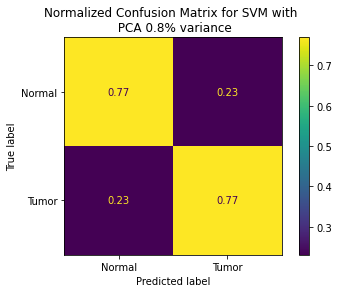

time: 218 ms (started: 2022-05-05 18:45:11 +00:00)


In [ ]:
# for item in pca_tuned_para_svm2:
#   x_train_sc23, x_test_sc23 = feature_scale(item["x_train_"], item["x_test_"])

#   disp = plot_confusion_matrix(item['model'], x_test_sc23, y_test)
#   plt.title("Confusion Matrix wtih " + str(item['variance_']) + "% variance (PCA)")
#   para_confMatrix.append(disp.confusion_matrix)
#   plt.show()

# best_item = pca_tuned_para_svm2[1]
best_item = pca_tuned_para_svm1
print(best_item["variance_"])
x_train_sc23_, x_test_sc23_ = feature_scale(best_item["x_train_"], best_item["x_test_"])

disp = plot_confusion_matrix(best_item['model'], x_test_sc23_, y_test, display_labels=["Normal", "Tumor"], normalize='true')
plt.title("Normalized Confusion Matrix for SVM with \n PCA " + str(best_item['variance_']) + "% variance")
confM = disp.confusion_matrix
plt.show()

In [ ]:
print(confM)

[[39 13]
 [16 53]]
time: 1.43 ms (started: 2022-05-02 01:42:21 +00:00)


## Per class accuracy

In [ ]:
# 0: normal
# 1: tumor

# print("Accuracy per class (no parameter tunning):")
# for i in range(len(para_confMatrix)):
#   print("The variance: " + str(selected_exp_var[i]))
#   row1_sum = np.array(para_confMatrix[i][0]).sum()
#   row2_sum = np.array(para_confMatrix[i][1]).sum()

#   acc_Normal = (para_confMatrix[i][0][0] / row1_sum)*100
#   acc_Tumor = (para_confMatrix[i][1][1] / row2_sum)*100

#   print(f"Normal accuracy: {acc_Normal}, Tumor accuracy: {acc_Tumor}")
#   print("")


print("The variance: 80%")
row1_sum = np.array(confM[0]).sum()
row2_sum = np.array(confM[1]).sum()

acc_Normal = (confM[0][0] / row1_sum)*100
acc_Tumor = (confM[1][1] / row2_sum)*100

print(f"Normal accuracy: {acc_Normal}, Tumor accuracy: {acc_Tumor}")
print("")

The variance: 80%
Normal accuracy: 75.0, Tumor accuracy: 76.81159420289855

time: 15.5 ms (started: 2022-05-02 01:42:21 +00:00)


## ROC

In [ ]:
from sklearn.metrics import roc_curve, auc

time: 1.16 ms (started: 2022-04-27 03:36:04 +00:00)


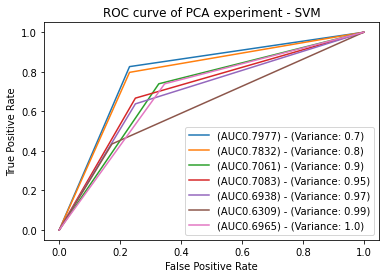

time: 363 ms (started: 2022-04-27 03:36:04 +00:00)


In [ ]:
for item in pca_tuned_para_svm2:
  x_train_sc23, x_test_sc23 = feature_scale(item["x_train_"], item["x_test_"])

  y_pred = item['model'].predict(x_test_sc23)

  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = np.round_(auc(fpr, tpr), decimals=4)
  txt = "(AUC" + str(roc_auc) + ") - (Variance: " + str(item["variance_"]) + ")"
  plt.plot(fpr, tpr, label=txt)

plt.title("ROC curve of PCA experiment - SVM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

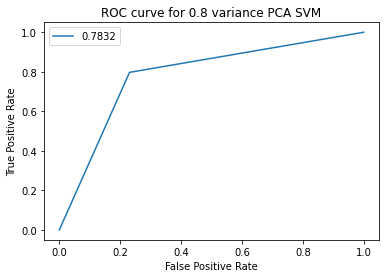

time: 196 ms (started: 2022-04-27 03:36:05 +00:00)


In [ ]:
# for item in x_train_exp:
y_pred = best_item['model'].predict(x_test_sc23_)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.round_(auc(fpr, tpr), decimals=4)
plt.plot(fpr, tpr, label=roc_auc)

plt.title("ROC curve for " + str(best_item["variance_"]) + " variance PCA SVM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

## Classification reports

In [ ]:
from sklearn.metrics import classification_report

time: 1.26 ms (started: 2022-04-27 03:36:05 +00:00)


In [ ]:
target_names = ['Normal', 'Tumor']
print("Classification report for " + str(best_item['variance_']))
y_pred = best_item['model'].predict(x_test_sc23_)
print(classification_report(y_test, y_pred, target_names=target_names))
print("\n\n")

Classification report for 0.8
              precision    recall  f1-score   support

      Normal       0.74      0.77      0.75        52
       Tumor       0.82      0.80      0.81        69

    accuracy                           0.79       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.79      0.79      0.79       121




time: 20.8 ms (started: 2022-04-27 03:36:05 +00:00)


# Save the best model

## Save the model

In [ ]:
import pickle

In [ ]:
SAVE_DIR = ROOT_DIR + "/saved_models/"

# no img aug
# FILE_NAME = "svm_mri_pca_noAug.pkl"

# img aug
FILE_NAME = "svm_mri_pca_Aug.pkl"

with open(SAVE_DIR+FILE_NAME,'wb') as f:
    pickle.dump(best_item['model'],f)

time: 3.43 ms (started: 2022-04-27 03:36:05 +00:00)


## Load the model

In [ ]:
SAVE_DIR = ROOT_DIR + "/saved_models/"

# no img aug
# FILE_NAME = "svm_mri_pca_noAug.pkl"

FILE_NAME = "svm_mri_pca_Aug.pkl"

loaded_model = pickle.load(open(SAVE_DIR+FILE_NAME, 'rb'))

result = loaded_model.score(x_train_exp[1]["x_test_"], x_train_exp[1]["y_test_"])